In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import factuality

# Setup

In [3]:
FACTUALITY_PATH = '../results/factuality'
PLOTS_PATH = '../results/plots'
LATEX_PATH = '../results/latex'

io.validate_path(FACTUALITY_PATH)
io.validate_path(PLOTS_PATH)
io.validate_path(LATEX_PATH)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_author.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_authors['task_name'] = io.pd.Categorical(df_authors['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_authors.shape


(138439, 33)

In [6]:
df_authors[['model','task_name','task_param','name','clean_name','id_author_oa','id_author_aps_list']]

,model,task_name,task_param,name,clean_name,id_author_oa,id_author_aps_list
0,llama3-8b,epoch,1950s,Richard Feynman,richard feynman,5.037711e+09,"[734559, 126319, 126320]"
1,llama3-8b,epoch,1950s,Julian Schwinger,julian schwinger,5.088439e+09,"[24088, 583913, 583916, 304481, 304482, 296925]"
2,llama3-8b,epoch,1950s,Sin-Itiro Tomonaga,sin itiro tomonaga,5.113844e+09,[98875]
3,llama3-8b,epoch,1950s,Murray Gell-Mann,murray gell mann,5.000902e+09,[768676]
4,llama3-8b,epoch,1950s,Chen Ning Yang,chen ning yang,5.101823e+09,"[36949, 862279, 404537, 621144]"
...,...,...,...,...,...,...,...
138434,llama-3.1-70b,twins,random_male,Juan José Saénz,juan jose saenz,5.072176e+09,"[51410, 765553, 779063, 785082, 538502, 830369..."
138435,llama-3.1-70b,twins,random_male,Pedro Rodríguez,pedro rodriguez,5.103537e+09,"[272704, 179440]"
138436,llama-3.1-70b,twins,random_male,Luis Manuel García,luis manuel garcia,5.103366e+09,"[45912, 699628]"
138437,llama-3.1-70b,twins,random_male,Antonio García Martínez,antonio garcia martinez,5.002026e+09,"[778446, 832978, 856932, 540719, 541033, 543774]"


# Factuality Author
Do they exist?

## Exists either in OA or APS

In [7]:
NONE = ['',' ','None',None,factuality.np.nan]
df_authors[['id_author_oa','id_author_aps_list']].query("id_author_aps_list not in @NONE")

# in OA and not in APS: 2042
# in APS not in OA: 0
# nowhere: 30411
# in APS: 105986
# in OA: 108028

,id_author_oa,id_author_aps_list
0,5.037711e+09,"[734559, 126319, 126320]"
1,5.088439e+09,"[24088, 583913, 583916, 304481, 304482, 296925]"
2,5.113844e+09,[98875]
3,5.000902e+09,[768676]
4,5.101823e+09,"[36949, 862279, 404537, 621144]"
...,...,...
138433,5.073974e+09,"[647150, 198277, 687709]"
138434,5.072176e+09,"[51410, 765553, 779063, 785082, 538502, 830369..."
138435,5.103537e+09,"[272704, 179440]"
138436,5.103366e+09,"[45912, 699628]"


In [8]:
df_fact_authors_either = factuality.get_factuality_authors_either_OA_APS(df_authors)
df_fact_authors_either.head(2)

,model,task_name,mean,std
0,gemma2-9b,top_k,0.6,0.0
1,gemma2-9b,field,0.6,0.0


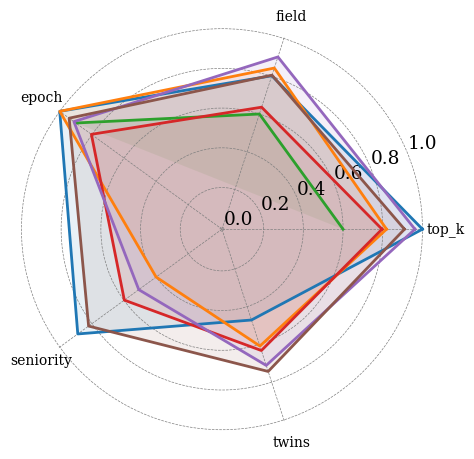

In [9]:
fname = 'factuality_author_mean_pct_real.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'task_name'
x_order = constants.EXPERIMENT_TASKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_fact_authors_either, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

In [10]:
df_fact_authors_either.groupby('model')['mean'].agg(['mean','std'])

,mean,std
model,,
gemma2-9b,0.700000,0.173205
llama-3.1-70b,0.843984,0.080459
llama-3.1-8b,0.734282,0.232991
llama3-70b,0.799138,0.188636
llama3-8b,0.832267,0.218366
mixtral-8x7b,0.693156,0.098320


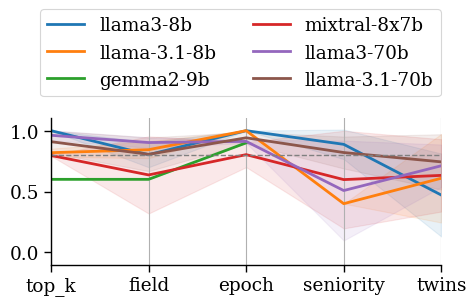

In [11]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_fact_field_mean_t = helpers.pivot_model_tasks(df_fact_authors_either, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_field_std_t = helpers.pivot_model_tasks(df_fact_authors_either, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)

vis.plot_parallel_coords(df_fact_field_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_field_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         ylim=constants.PLOT_YLIM_PARALLEL_PCT,
                         legend=True,
                         fn=fn,
                         axhline={'y':0.8, 'ls':'--', 'c':'grey', 'lw':1.0}
                         )

### For Slides

/var/folders/lj/_xkc5wfx66n7wxk15hc05rjm0000gn/T/ipykernel_39898/4002403646.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['task_name'] = pd.Categorical(tmp['task_name'], categories=task_order, ordered=True)
/var/folders/lj/_xkc5wfx66n7wxk15hc05rjm0000gn/T/ipykernel_39898/4002403646.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['model'] = pd.Categorical(tmp['model'], categories=model_order, ordered=True)


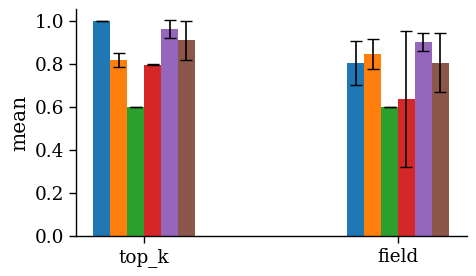

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

task_order = ['top_k','field']

tmp = df_fact_authors_either.query("task_name in @task_order")

model_order = constants.LLMS

# Convert to categorical for ordering
tmp['task_name'] = pd.Categorical(tmp['task_name'], categories=task_order, ordered=True)
tmp['model'] = pd.Categorical(tmp['model'], categories=model_order, ordered=True)

# Pivot the data with enforced order
pivot_mean = tmp.pivot(index='task_name', columns='model', values='mean').loc[task_order, model_order]
pivot_std = tmp.pivot(index='task_name', columns='model', values='std').loc[task_order, model_order]

# Plot
x = np.arange(len(task_order))
width = 0.4 / len(model_order)  # total width of bars per group
offsets = np.linspace(-width * (len(model_order) - 1) / 2, width * (len(model_order) - 1) / 2, len(model_order))

fig, ax = plt.subplots(figsize=(5, 3))

for i, model in enumerate(model_order):
    ax.bar(
        x + offsets[i],
        pivot_mean[model],
        width,
        yerr=pivot_std[model],
        label=model,
        capsize=4
    )

# Formatting
# ax.set_xlabel("Task Name")
ax.set_ylabel("mean")
# ax.set_title("Performance by Task and Model")
ax.set_xticks(x)
ax.set_xticklabels(task_order, rotation=0, ha='center')
# ax.legend(None)
plt.tight_layout()

plt.subplots_adjust(wspace=0.0, hspace=0.01)

# vis._polish_plot(fig, ax, x_col='task_name', y_col='mean', group_order=model_order)
vis._finish_plot(fig, None)

plt.show()
plt.close()

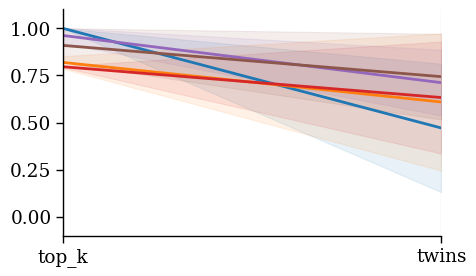

In [13]:

fn = None

df_fact_field_mean_t = helpers.pivot_model_tasks(df_fact_authors_either, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_field_std_t = helpers.pivot_model_tasks(df_fact_authors_either, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)

# removing tasks
df_fact_field_mean_t = df_fact_field_mean_t.drop(columns=['field','epoch','seniority'])
df_fact_field_std_t = df_fact_field_std_t.drop(columns=['field','epoch','seniority'])

vis.plot_parallel_coords(df_fact_field_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_field_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=(5,3),
                         ylim=constants.PLOT_YLIM_PARALLEL_PCT,
                         legend=False,
                         fn=fn)

## Only in one of them

In [14]:
df_fact_authors_both, df_fact_authors_oa, df_fact_authors_none = factuality.get_factuality_author_for_each_case(df_authors)
df_fact_authors_both.head(2)

,model,task_name,mean,std
0,gemma2-9b,top_k,0.6,0.0
1,gemma2-9b,field,0.6,0.0


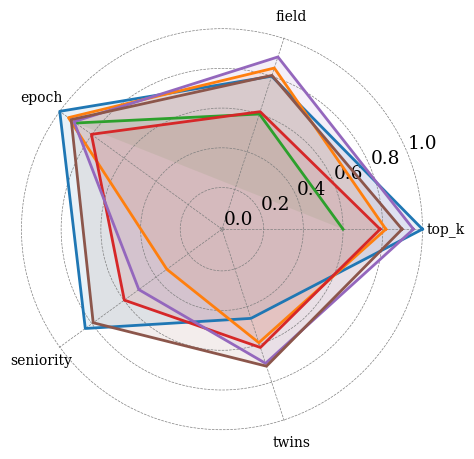

In [15]:
fn = None #io.path_join(PLOTS_PATH, 'factuality_author_mean_pct_both.pdf')
vis.plot_spiderweb(df_fact_authors_both, x_order=constants.EXPERIMENT_TASKS, x_col='task_name', y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT,
                   legend=False,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

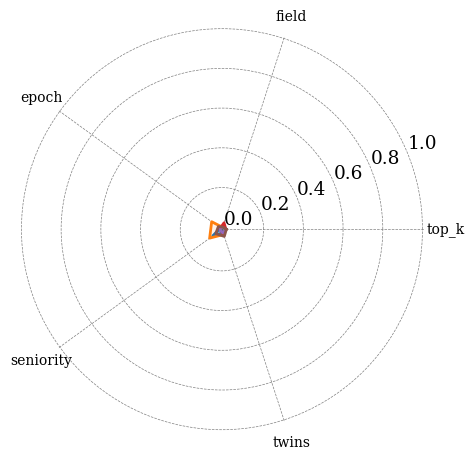

In [16]:

fn = None #io.path_join(PLOTS_PATH, 'factuality_author_mean_pct_both.pdf')
vis.plot_spiderweb(df_fact_authors_oa, x_order=constants.EXPERIMENT_TASKS, x_col='task_name', y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, legend=False,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

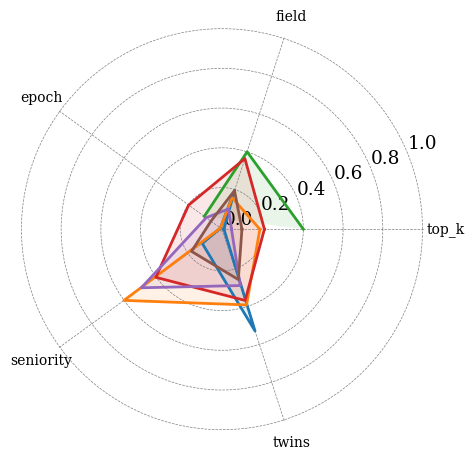

In [17]:

fn = None #io.path_join(PLOTS_PATH, 'factuality_author_mean_pct_both.pdf')
vis.plot_spiderweb(df_fact_authors_none, x_order=constants.EXPERIMENT_TASKS, x_col='task_name', y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT,legend=False,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)

# Factuality Field

In [18]:
df_field = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_FIELD}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)
df_field.shape

(15861, 20)

In [19]:
df_field.groupby(['model','task_param']).size()

model          task_param
gemma2-9b      PER            465
llama-3.1-70b  CM&MP         1714
               PER            812
llama-3.1-8b   PER            690
llama3-70b     CM&MP          316
               PER           1070
llama3-8b      CM&MP          936
               PER            930
mixtral-8x7b   CM&MP         1953
               PER           6975
dtype: int64

In [20]:
fname = 'factuality_field_mean_pct.tex'
fn = io.path_join(LATEX_PATH, fname)

df_fact_field_param = factuality.get_factuality_field_param(df_field)
io.save_text(df_fact_field_param.to_latex(), fn)

In [21]:
df_fact_field = factuality.get_factuality_field(df_field)
df_fact_field.head(3)

,model,factuality_field,mean,std
0,gemma2-9b,Author,0.6,0.0
1,gemma2-9b,A.D.F.,0.0,0.0
2,gemma2-9b,DOI,0.0,0.0


In [22]:
df_fact_field.groupby('model')['mean'].mean().sort_values()

model
gemma2-9b        0.200000
mixtral-8x7b     0.362857
llama-3.1-70b    0.523353
llama-3.1-8b     0.551208
llama3-70b       0.556376
llama3-8b        0.583289
Name: mean, dtype: float64

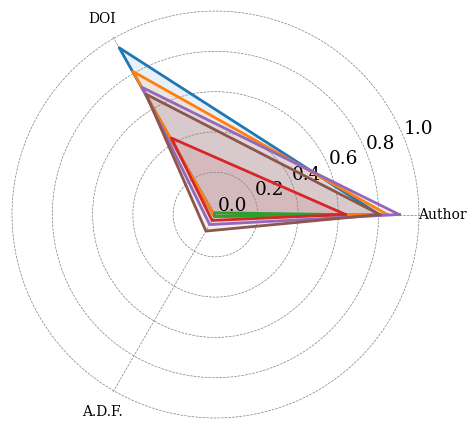

In [23]:
fn = io.path_join(PLOTS_PATH, fname.replace('.tex','.pdf'))

hue = 'model'
x_col = 'factuality_field'
x_order = constants.FACTUALITY_FIELD_FACT_CHECKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_fact_field, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)



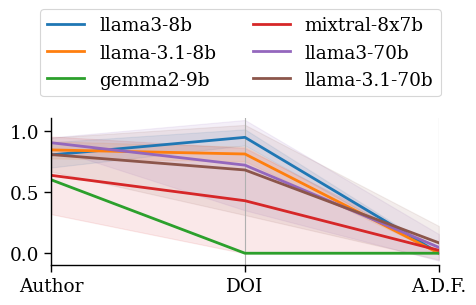

In [24]:
fn = io.path_join(PLOTS_PATH, fname.replace('.tex','_parallel_coords.pdf'))

df_fact_field_mean_t = helpers.pivot_model_tasks(df_fact_field, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_field_std_t = helpers.pivot_model_tasks(df_fact_field, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_fact_field_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_field_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         ylim=constants.PLOT_YLIM_PARALLEL_PCT,
                         fn=fn)

# Seniority

In [25]:
df_seniority = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_SENIORITY}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)
df_seniority.shape

/var/folders/lj/_xkc5wfx66n7wxk15hc05rjm0000gn/T/ipykernel_39898/4055560821.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_seniority = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_SENIORITY}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)


(10860, 24)

In [26]:
fname = 'factuality_seniority_mean_pct.tex'
fn = io.path_join(LATEX_PATH, fname)

df_fact_seniority_param = factuality.get_factuality_seniority_param(df_seniority)
io.save_text(df_fact_seniority_param.to_latex(), fn)

In [27]:
df_fact_seniority = factuality.get_factuality_seniority(df_seniority)
df_fact_seniority.head(10)

,model,factuality_field,mean,std
16,llama3-70b,Author,0.50771,0.410098
28,mixtral-8x7b,Author,0.597838,0.401080
4,llama-3.1-70b,Author,0.820235,0.131141
10,llama-3.1-8b,Author,0.4,0.000000
22,llama3-8b,Author,0.887659,0.121582
17,llama3-70b,None,0.49229,0.410098
11,llama-3.1-8b,None,0.6,0.000000
29,mixtral-8x7b,None,0.402162,0.401080
5,llama-3.1-70b,None,0.179765,0.131141
23,llama3-8b,None,0.112341,0.121582


In [28]:
df_fact_seniority.groupby('model')['mean'].mean().sort_values()

model
llama-3.1-8b     0.233333
llama-3.1-70b     0.30314
llama3-70b       0.397705
mixtral-8x7b      0.44045
llama3-8b        0.441095
Name: mean, dtype: object

gemma2-9b (0, 4) single positional indexer is out-of-bounds


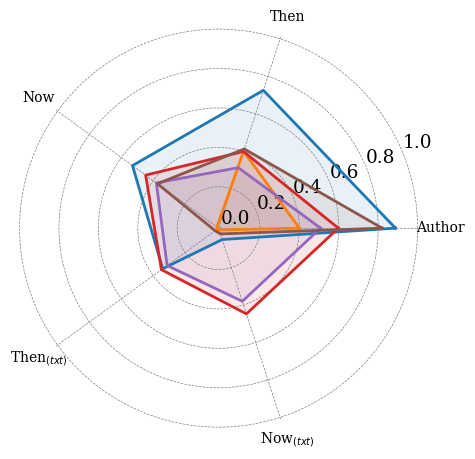

In [29]:
fn = io.path_join(PLOTS_PATH, fname.replace('.tex','.pdf'))

hue = 'model'
x_col = 'factuality_field'
x_order = constants.FACTUALITY_SENIORITY_FACT_CHECKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_fact_seniority, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)


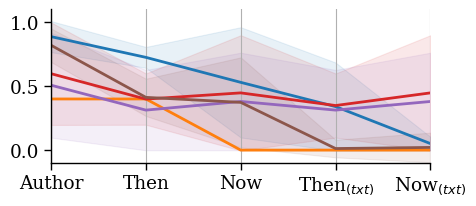

In [30]:
fn = io.path_join(PLOTS_PATH, fname.replace('.tex','_parallel_coords.pdf'))

df_fact_seniority_mean_t = helpers.pivot_model_tasks(df_fact_seniority, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_seniority_std_t = helpers.pivot_model_tasks(df_fact_seniority, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_fact_seniority_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_seniority_std_t, 
                         legend=False,
                         figsize=constants.PLOT_FIGSIZE_NO_LEGEND,
                         ylim=constants.PLOT_YLIM_PARALLEL_PCT,
                         fn=fn)

# Epoch

In [31]:
df_epoch = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_{constants.EXPERIMENT_TASK_EPOCH}.csv"), index_col=0) for model in constants.LLMS ], ignore_index=True)
df_epoch.shape

(11760, 21)

In [32]:
fname = 'factuality_epoch_mean_pct.tex'
fn = io.path_join(LATEX_PATH, fname)

df_fact_epoch_param = factuality.get_factuality_epoch_param(df_epoch)
io.save_text(df_fact_epoch_param.to_latex(), fn)

In [ ]:
df_fact_epoch = factuality.get_factuality_epoch(df_epoch)
df_fact_epoch.head(2)

,model,factuality_field,mean,std
10,llama-3.1-70b,Author,0.940890,0.047501
22,llama3-70b,Author,0.911869,0.012796


In [35]:
df_fact_epoch.groupby('model')['mean'].mean().sort_values()

model
llama3-8b        0.378788
mixtral-8x7b     0.418044
llama-3.1-8b     0.462963
llama-3.1-70b    0.468269
llama3-70b       0.481773
gemma2-9b        0.516667
Name: mean, dtype: float64

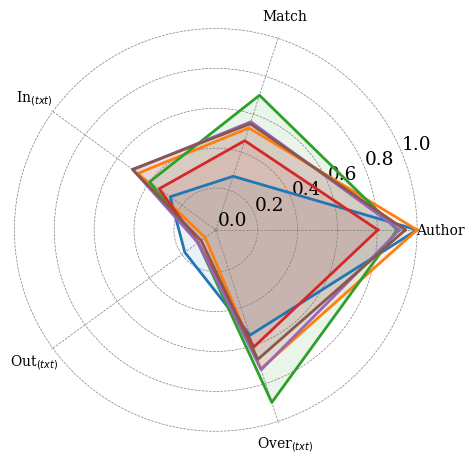

In [36]:
fname = 'factuality_epoch_mean_pct.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'factuality_field'
x_order = constants.FACTUALITY_EPOCH_FACT_CHECKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_fact_epoch, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   legend=False, fn=fn,
                   figsize=constants.PLOT_FIGSIZE_SPIDER_NO_LEGEND)


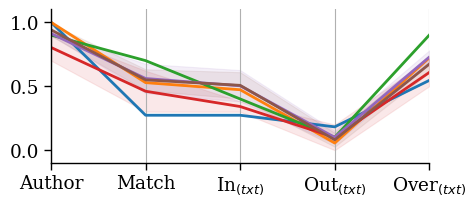

In [37]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_fact_epoch_mean_t = helpers.pivot_model_tasks(df_fact_epoch, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_fact_epoch_std_t = helpers.pivot_model_tasks(df_fact_epoch, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_fact_epoch_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_fact_epoch_std_t, 
                         legend=False,
                         figsize=constants.PLOT_FIGSIZE_NO_LEGEND,
                         ylim=constants.PLOT_YLIM_PARALLEL_PCT,
                         fn=fn)